In [1]:
import pandas as pd
import networkx as nx
import geopy.distance
import matplotlib.pyplot as plt

/Users/gurkan/coding/python/tokenizer/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
class SNCFTrainNetwork:
    def __init__(self, train_lines_file, gares_file):
        # Charger les données
        self.train_lines = pd.read_json(train_lines_file)
        self.gares = pd.read_json(gares_file)
        
        # Créer un graphe pour le réseau ferroviaire
        self.graph = nx.Graph()
        
        # Construire le graphe
        self._build_graph()
    
    def _build_graph(self):
        """
        Construire le graphe du réseau ferroviaire
        """
        # Ajouter les points des lignes ferroviaires
        for _, ligne in self.train_lines.iterrows():
            start_node = (ligne['c_geo_d']['lon'], ligne['c_geo_d']['lat'])
            end_node = (ligne['c_geo_f']['lon'], ligne['c_geo_f']['lat'])
            
            distance = geopy.distance.distance(
                (start_node[1], start_node[0]), 
                (end_node[1], end_node[0])
            ).kilometers
            
            self.graph.add_edge(start_node, end_node, weight=distance)
        
        # Ajouter les gares au graphe
        for _, gare in self.gares.iterrows():
            gare_coords = (
                gare['position_geographique']['lon'], 
                gare['position_geographique']['lat']
            )
            
            # Trouver le point ferroviaire le plus proche
            nearest_point = min(
                self.graph.nodes(), 
                key=lambda x: geopy.distance.distance(gare_coords, x).kilometers
            )
            
            # Connecter la gare au point ferroviaire le plus proche
            distance_to_nearest = geopy.distance.distance(
                gare_coords, nearest_point
            ).kilometers
            
            self.graph.add_edge(gare_coords, nearest_point, weight=distance_to_nearest)
    
    def find_route(self, start_city, end_city):
        """
        Trouver la route entre deux villes
        """
        start_gare = self.gares[self.gares['nom'].str.lower().str.contains(start_city.lower())]
        end_gare = self.gares[self.gares['nom'].str.lower().str.contains(end_city.lower())]
        
        if start_gare.empty or end_gare.empty:
            return "Gares introuvables"
        
        start_coords = (
            start_gare.iloc[0]['position_geographique']['lon'], 
            start_gare.iloc[0]['position_geographique']['lat']
        )
        end_coords = (
            end_gare.iloc[0]['position_geographique']['lon'], 
            end_gare.iloc[0]['position_geographique']['lat']
        )
        
        try:
            route = nx.shortest_path(
                self.graph, 
                source=start_coords, 
                target=end_coords, 
                weight='weight'
            )
            
            return {
                'start': start_gare.iloc[0]['nom'],
                'end': end_gare.iloc[0]['nom'],
                'route_points': route,
                'total_distance': nx.path_weight(self.graph, route, weight='weight')
            }
        except nx.NetworkXNoPath:
            return "Pas de route ferroviaire trouvée"
    
    def visualize_network(self):
        """
        Visualiser le réseau ferroviaire
        """
        plt.figure(figsize=(15, 10))
        
        node_coords = list(self.graph.nodes())
        x = [node[0] for node in node_coords]
        y = [node[1] for node in node_coords]
        
        plt.scatter(x, y, s=1, c='blue', alpha=0.5)
        plt.title("Réseau Ferroviaire SNCF")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.tight_layout()
        plt.show()


In [3]:
network = SNCFTrainNetwork('assets/liste-des-circuits-de-voie.json', 'assets/gares-de-voyageurs.json')

KeyboardInterrupt: 

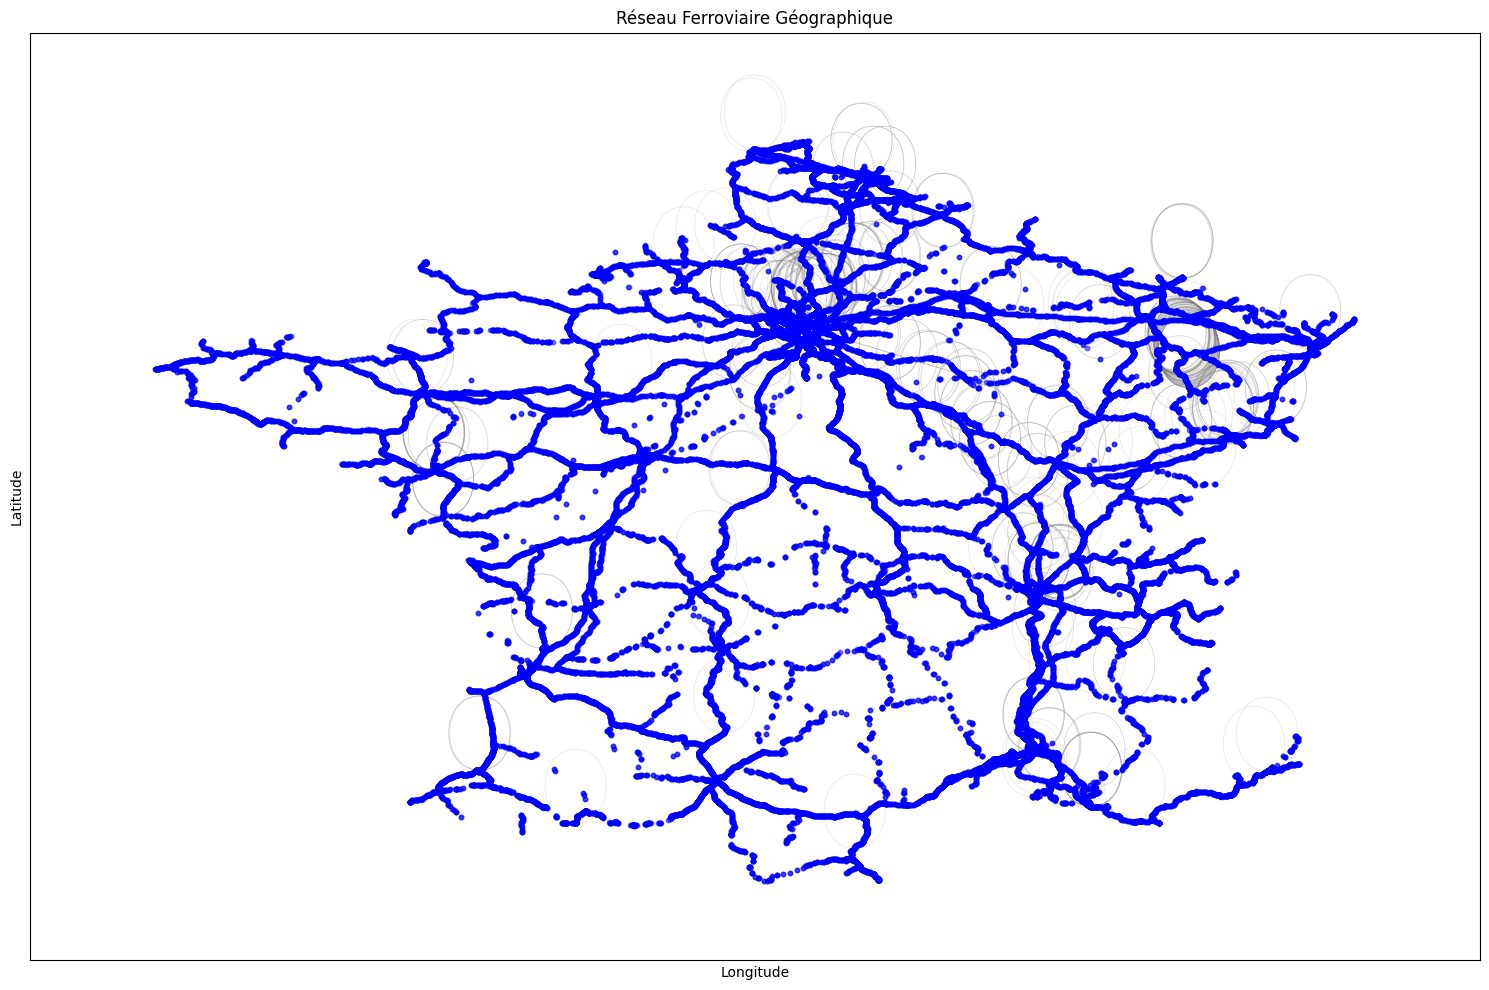

In [4]:
graphe_sncf.visualiser_graphe()

In [5]:
graphe_sncf.analyser_reseau()

Analyse du réseau ferroviaire:
Nombre total de nœuds : 90216
Nombre total d'arêtes : 74309

Points les plus centraux :
Point (2.559384259503563, 49.00959878965037) : Centralité 0.0001
Point (6.970003767784776, 43.5678700577584) : Centralité 0.0001
Point (2.0756323999052695, 48.79856512926544) : Centralité 0.0001
Point (-1.9845006269312913, 48.15594637040731) : Centralité 0.0001
Point (4.347612839646931, 48.956830424510215) : Centralité 0.0001


In [6]:
depart = (48.573405, 7.752111)  # Gare de Strasbourg
arrivee = (47.746543, 7.338584)  # Gare de Mulhouse

In [7]:
chemin, distance = graphe_sncf.trouver_chemin_optimal(depart, arrivee)

Noeud départ trop éloigné : (7.600996133784283, 43.794544157230284)


In [8]:
if chemin:
    print("\nChemin optimal:")
    for point in chemin:
        print(f"Point: {point}")
    print(f"Distance totale : {distance:.2f} km")